In [1]:
from typing import List, Tuple
from math import sqrt
from matplotlib import pyplot as plt
from pprint import pprint

import numpy as np
from src.kernel.quantum_state import FreeQuantumState
from src.kernel.timeline import Timeline
from src.components.polarizer import Polarizer

detector0_singles_count = 0
detector1_singles_count = 0
coincidence_count = 0
  
detector0_singles = []
detector1_singles = []
coincidence = []
singled_coincidences = []

default_rng = np.random.default_rng()

two_qubit_basis = ((
                (complex(1), complex(0), complex(0), complex(0)),
                (complex(0), complex(1), complex(0), complex(0)),
                (complex(0), complex(0), complex(1), complex(0)),
                (complex(0), complex(0), complex(0), complex(1))
            ))
one_qubit_basis = (
                        (complex(0), complex(1)),
                        (complex(1), complex(0))
                  )   

### Define Polarizer

In [2]:
tl = Timeline(1e12)
pol = Polarizer("Polarizer", tl, num_qubits=2)
pol_single_qubit = Polarizer("single_qubit_Polarizer", tl, num_qubits=1)

def _generate_tmsv_state(mean_photon_num, truncation):
    """Method to generate two-mode squeezed vacuum state of two output photonic modes

    Returns:
        array: generated state.
    """

    mean_num = mean_photon_num
    truncation = truncation

    # print("truncation is:", truncation)

    # create state component amplitudes list
    amp_list = [(sqrt(mean_num / (mean_num + 1)) ** m) / sqrt(mean_num + 1) for m in range(truncation)]
    amp_square_list = [amp ** 2 for amp in amp_list]
    amp_list.append(sqrt(1 - sum(amp_square_list)))

    # create two-mode state vector
    state_vec = np.zeros((truncation+1) ** 2)

    for i in range(truncation+1):
        amp = amp_list[i]
        basis = np.zeros(truncation+1)
        basis[i] = 1
        basis = np.kron(basis,basis)
        state_vec += amp * basis

    return state_vec

entity name: Polarizer
entity name: single_qubit_Polarizer


### Main Loop

In [3]:
fringe_domain = np.linspace(0, 2*np.pi, num = 50)
max_iter = 1000

# fringe_domain = [np.pi/8]
# max_iter = 1

# original_state = (0.5*complex(1/sqrt(2)), complex(0), complex(0), 0.5*complex(1/sqrt(2)))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    singled_coincidences_count = 0
    for iter in range(max_iter):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
            pass # We had coincidence. Send the detection event to both the detectors.
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.get(bell_state[1])

            # print("quantum state 0:\n", bell_state[0].state)
            # print("quantum state 1:\n", bell_state[1].state)
            
            # detect0_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob=True)
            # detect1_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob=True)

            if not bell_state[0].measure(one_qubit_basis, default_rng):
                detector0_singles_count += 1
                pass # send measurment signal to detector0

            if not bell_state[1].measure(one_qubit_basis, default_rng):
                detector1_singles_count += 1
                pass # send measurment signal to detector1
    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count + 0.5*coincidence_count)
    detector1_singles.append(detector1_singles_count + 0.5*coincidence_count)
                
                
    # coincidence.append(coincidence_count)
    # detector0_singles.append(detector0_singles_count + coincidence_count)
    # detector1_singles.append(detector1_singles_count + coincidence_count)
    # singled_coincidences.append(singled_coincidences_count)
        
# ylim = max(max(coincidence, detector0_singles, detector1_singles))
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.ylim([0, max(coincidence)])
# plt.figure()
# plt.plot(fringe_domain, singled_coincidences)
# plt.title("Singled coincidences")
# plt.ylim([0, max(singled_coincidences)])
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.ylim([0, max(detector0_singles)])
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
plt.ylim([0, max(detector1_singles)])
coincidence = []
detector0_singles = []
detector1_singles = []

theta: 0.0


TypeError: 'numpy.complex128' object is not iterable

theta: 0.0
theta: 0.1282282715750936
theta: 0.2564565431501872
theta: 0.38468481472528077
theta: 0.5129130863003744
theta: 0.6411413578754679
theta: 0.7693696294505615
theta: 0.8975979010256552
theta: 1.0258261726007487
theta: 1.1540544441758422
theta: 1.2822827157509358
theta: 1.4105109873260295
theta: 1.538739258901123
theta: 1.6669675304762166
theta: 1.7951958020513104
theta: 1.9234240736264039
theta: 2.0516523452014974
theta: 2.179880616776591
theta: 2.3081088883516845
theta: 2.436337159926778
theta: 2.5645654315018716
theta: 2.6927937030769655
theta: 2.821021974652059
theta: 2.9492502462271526
theta: 3.077478517802246
theta: 3.2057067893773397
theta: 3.333935060952433
theta: 3.4621633325275267
theta: 3.5903916041026207
theta: 3.7186198756777142
theta: 3.8468481472528078
theta: 3.9750764188279013
theta: 4.103304690402995
theta: 4.231532961978089
theta: 4.359761233553182
theta: 4.487989505128276
theta: 4.616217776703369
theta: 4.744446048278463
theta: 4.872674319853556
theta: 5.0009

/tmp/ipykernel_2226139/958167976.py:85: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim([0, max(coincidence)])


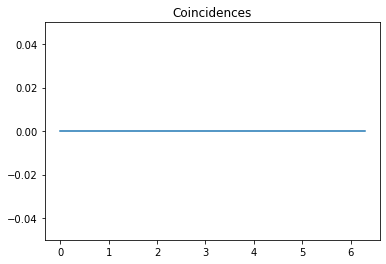

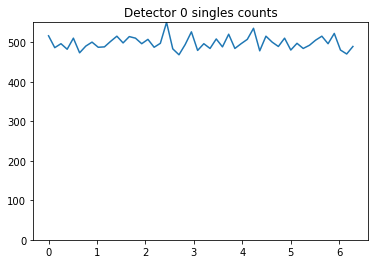

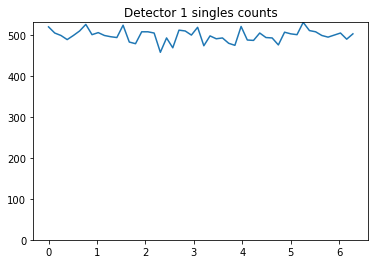

In [ ]:
fringe_domain = np.linspace(0, 2*np.pi, num = 50)
max_iter = 1000

# fringe_domain = [np.pi/8]
# max_iter = 1

# original_state = (0.5*complex(1/sqrt(2)), complex(0), complex(0), 0.5*complex(1/sqrt(2)))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    singled_coincidences_count = 0
    for iter in range(max_iter):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        # states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)

        # if default_rng.random() < probabilities[-1]: # Checking the coincidence probability in the VV basis. 
        #     coincidence_count += 1
        #     pass # We had coincidence. Send the detection event to both the detectors.
        # else:


        bell_state[0].set_state(original_state)
        bell_state[0].split_states()

        pol_single_qubit.rotate({0:theta})
        pol_single_qubit.get(bell_state[0])

        pol_single_qubit.rotate({0:np.pi})
        pol_single_qubit.get(bell_state[1])

        # print("quantum state 0:\n", bell_state[0].state)
        # print("quantum state 1:\n", bell_state[1].state)
        
        detect0_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob=True)
        detect1_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob=True)

        # if np.random.rand() < detect0_prob:
        #     detector0_singles_count += 1
        # if np.random.rand() < detect1_prob:
        #     detector1_singles_count += 1

        if np.random.rand() < detect0_prob:
            detector0_result = 1
        else:
            detector0_result = 0
        
        if np.random.rand() < detect1_prob:
            detector1_result = 1
        else:
            detector1_result = 0
                
            # if not detector0_result and detector1_result:
            #     detector0_singles_count += detector0_result
            #     detector1_singles_count += detector1_result
            #     break
            

    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count)
    detector1_singles.append(detector1_singles_count)
                
                
    # coincidence.append(coincidence_count)
    # detector0_singles.append(detector0_singles_count + coincidence_count)
    # detector1_singles.append(detector1_singles_count + coincidence_count)
    # singled_coincidences.append(singled_coincidences_count)
        
# ylim = max(max(coincidence, detector0_singles, detector1_singles))
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.ylim([0, max(coincidence)])
# plt.figure()
# plt.plot(fringe_domain, singled_coincidences)
# plt.title("Singled coincidences")
# plt.ylim([0, max(singled_coincidences)])
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.ylim([0, max(detector0_singles)])
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
plt.ylim([0, max(detector1_singles)])
coincidence = []
detector0_singles = []
detector1_singles = []

theta: 0.0
theta: 0.1282282715750936
theta: 0.2564565431501872
theta: 0.38468481472528077
theta: 0.5129130863003744
theta: 0.6411413578754679
theta: 0.7693696294505615
theta: 0.8975979010256552
theta: 1.0258261726007487
theta: 1.1540544441758422
theta: 1.2822827157509358
theta: 1.4105109873260295
theta: 1.538739258901123
theta: 1.6669675304762166
theta: 1.7951958020513104
theta: 1.9234240736264039
theta: 2.0516523452014974
theta: 2.179880616776591
theta: 2.3081088883516845
theta: 2.436337159926778
theta: 2.5645654315018716
theta: 2.6927937030769655
theta: 2.821021974652059
theta: 2.9492502462271526
theta: 3.077478517802246
theta: 3.2057067893773397
theta: 3.333935060952433
theta: 3.4621633325275267
theta: 3.5903916041026207
theta: 3.7186198756777142
theta: 3.8468481472528078
theta: 3.9750764188279013
theta: 4.103304690402995
theta: 4.231532961978089
theta: 4.359761233553182
theta: 4.487989505128276
theta: 4.616217776703369
theta: 4.744446048278463
theta: 4.872674319853556
theta: 5.0009

(0.0, 514.0)

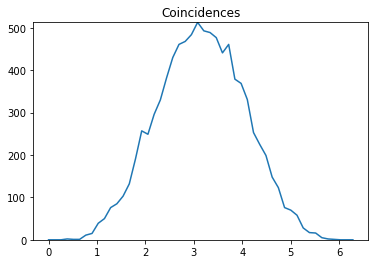

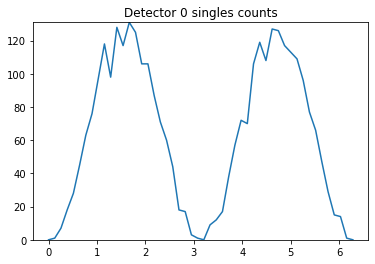

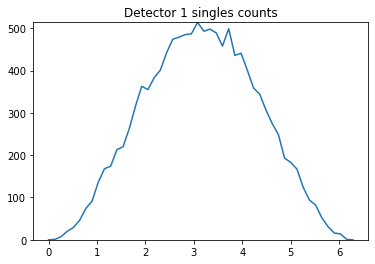

In [ ]:
coincidence = []
detector0_singles = []
detector1_singles = []
fringe_domain = np.linspace(0, 2*np.pi, num = 50)
max_iter = 1000

# fringe_domain = [np.pi/8]
# max_iter = 1

# original_state = (0.5*complex(1/sqrt(2)), complex(0), complex(0), 0.5*complex(1/sqrt(2)))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    singled_coincidences_count = 0
    for iter in range(max_iter):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        
        # print("Probabilites are:", probabilities)

        sample = np.random.rand()

        if sample < probabilities[3]:
            coincidence_count += 1
        elif probabilities[3] < sample < probabilities[3] + probabilities[2]:
            detector0_singles_count += 1        


        # bell_state[0].set_state(original_state)
        # bell_state[0].split_states()

        # pol_single_qubit.rotate({0:theta})
        # pol_single_qubit.get(bell_state[0])

        # pol_single_qubit.rotate({0:np.pi})
        # pol_single_qubit.get(bell_state[1])

        # # print("quantum state 0:\n", bell_state[0].state)
        # # print("quantum state 1:\n", bell_state[1].state)
        
        # detect0_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob=True)
        # detect1_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob=True)

        # # if np.random.rand() < detect0_prob:
        # #     detector0_singles_count += 1
        # # if np.random.rand() < detect1_prob:
        # #     detector1_singles_count += 1

        # if np.random.rand() < detect0_prob:
        #     detector0_result = 1
        # else:
        #     detector0_result = 0
        
        # if np.random.rand() < detect1_prob:
        #     detector1_result = 1
        # else:
        #     detector1_result = 0
                
        #     # if not detector0_result and detector1_result:
        #     #     detector0_singles_count += detector0_result
        #     #     detector1_singles_count += detector1_result
        #     #     break
            

    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count)
    detector1_singles.append(coincidence_count+detector0_singles_count)
                
                
    # coincidence.append(coincidence_count)
    # detector0_singles.append(detector0_singles_count + coincidence_count)
    # detector1_singles.append(detector1_singles_count + coincidence_count)
    # singled_coincidences.append(singled_coincidences_count)
        
# ylim = max(max(coincidence, detector0_singles, detector1_singles))
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.ylim([0, max(coincidence)])
# plt.figure()
# plt.plot(fringe_domain, singled_coincidences)
# plt.title("Singled coincidences")
# plt.ylim([0, max(singled_coincidences)])
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.ylim([0, max(detector0_singles)])
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
plt.ylim([0, max(detector1_singles)])

state_density: [[0.25+0.j 0.  +0.j 0.  +0.j 0.25+0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.25+0.j 0.  +0.j 0.  +0.j 0.25+0.j]]
theta: 1.0471975511965976
states:
 [[[ 0.+0.j -0.+0.j  0.+0.j  0.+0.j]
  [-0.+0.j  1.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]

 [[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
  [ 0.+0.j  0.+0.j  0.+0.j -0.+0.j]
  [ 0.+0.j  0.+0.j -0.+0.j  1.+0.j]]]
probabilities:
 [0.04687500000000001, 0.015624999999999997]


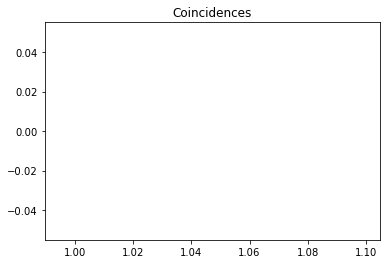

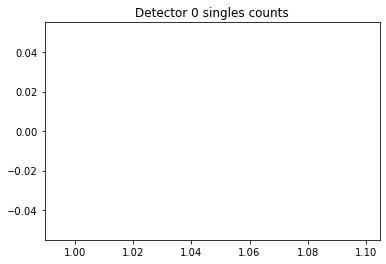

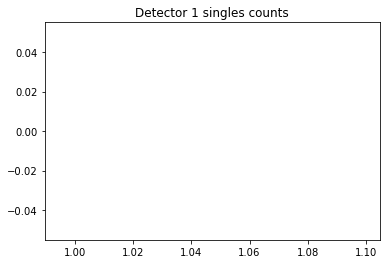

In [ ]:
fringe_domain = np.linspace(0, 2*np.pi, num = 50)
original_state = (complex(0.5), complex(0), complex(0), complex(0.5))
state_density = np.outer(original_state, np.array(original_state).conj())
print("state_density:", state_density)
total_iterations = 10000
# original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


# Experimental parameters
fringe_domain = [np.pi/3]
total_iterations = 1
for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(total_iterations):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(state_density, density_matrix=True)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        # pol.rotate({0:theta, 1:np.pi})
        # pol.get(bell_state[0])

        states, probabilities = bell_state[0].measure(one_qubit_basis, default_rng, return_prob=True)
        # coincidence_prob = sum(probabilities)

        print("states:\n", np.round(states))
        print("probabilities:\n", probabilities)

        # if default_rng.random() < coincidence_prob:
        #     coincidence_count += 1
        #     pass # We had coincidence. Send the detection event to both the detectors.
        # else:
        #     bell_state[0].set_state(original_state)
        #     bell_state[0].split_states()

        #     pol_single_qubit.rotate({0:theta})
        #     pol_single_qubit.get(bell_state[0])

        #     pol_single_qubit.rotate({0:np.pi})
        #     pol_single_qubit.get(bell_state[1])
            
        #     if not bell_state[0].measure(one_qubit_basis, default_rng):
        #         detector0_singles_count += 1
        #         pass # send measurment signal to detector0

        #     if not bell_state[1].measure(one_qubit_basis, default_rng):
        #         detector1_singles_count += 1
        #         pass # send measurment signal to detector1
    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count + coincidence_count)
    detector1_singles.append(detector1_singles_count + coincidence_count)
        
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
coincidence = []
detector0_singles = []
detector1_singles = []

In [ ]:
fringe_domain = np.linspace(0, 2*np.pi, num = 50)
original_state = (complex(np.sqrt(3)/2), complex(0), complex(0), complex(0.5))
# original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)

# fringe_domain = [np.pi/3]
for theta in fringe_domain:
    print("theta:", theta)
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(10000):        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # print("entangkled states:", bell_state[0].state, bell_state[1].state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
            pass # We had coincidence. Send the detection event to both the detectors.
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.get(bell_state[1])
            
            if not bell_state[0].measure(one_qubit_basis, default_rng):
                detector0_singles_count += 1
                pass # send measurment signal to detector0

            if not bell_state[1].measure(one_qubit_basis, default_rng):
                detector1_singles_count += 1
                pass # send measurment signal to detector1
    coincidence.append(coincidence_count)
    detector0_singles.append(detector0_singles_count)
    detector1_singles.append(detector1_singles_count)
        
plt.figure()
plt.plot(fringe_domain, coincidence)
plt.title("Coincidences")
plt.figure()
plt.plot(fringe_domain, detector0_singles)
plt.title("Detector 0 singles counts")
plt.figure()
plt.plot(fringe_domain, detector1_singles)
plt.title("Detector 1 singles counts")
coincidence = []
detector0_singles = []
detector1_singles = []

In [ ]:
coincidenceH = []
detector0_singlesH = []
detector1_singlesH = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        # pol.rotate({0:theta, 1:np.pi})
        pol.rotate({0:theta, 1:0})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            # pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.rotate({0:0})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceH.append(coincidence_count)
    detector0_singlesH.append(detector0_singles_count + coincidence_count)
    detector1_singlesH.append(detector1_singles_count + coincidence_count)
        


/tmp/ipykernel_2452664/1188817735.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])


In [ ]:
coincidenceV = []
detector0_singlesV = []
detector1_singlesV = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        pol.rotate({0:theta, 1:np.pi})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceV.append(coincidence_count)
    detector0_singlesV.append(detector0_singles_count + coincidence_count)
    detector1_singlesV.append(detector1_singles_count + coincidence_count)
        


/tmp/ipykernel_2452664/3367985791.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])


In [ ]:
coincidenceL = []
detector0_singlesL = []
detector1_singlesL = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        pol.rotate({0:theta, 1:np.pi/2})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:np.pi/2})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceL.append(coincidence_count)
    detector0_singlesL.append(detector0_singles_count + coincidence_count)
    detector1_singlesL.append(detector1_singles_count + coincidence_count)
        


/tmp/ipykernel_2452664/1532794341.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])


In [ ]:
coincidenceR = []
detector0_singlesR = []
detector1_singlesR = []
fringe_domain = np.linspace(0, 2*np.pi, num = 100)
# original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))
# original_state = _generate_tmsv_state(0.01, 1)


for theta in fringe_domain:
    coincidence_count = 0
    detector0_singles_count = 0
    detector1_singles_count = 0
    for iter in range(1000):
        
        bell_state = [FreeQuantumState(), FreeQuantumState()]
        bell_state[0].combine_state(bell_state[1])
        bell_state[0].set_state(original_state)

        pol.rotate({0:theta, 1:3*np.pi/2})
        pol.get(bell_state[0])

        states, probabilities = FreeQuantumState.measure_multiple(two_qubit_basis, [bell_state[0], bell_state[1]], default_rng, return_states=True)
        coincidence_prob = sum(probabilities)

        if default_rng.random() < coincidence_prob:
            coincidence_count += 1
        else:
            bell_state[0].set_state(original_state)
            bell_state[0].split_states()

            pol_single_qubit.rotate({0:theta})
            pol_single_qubit.get(bell_state[0])

            pol_single_qubit.rotate({0:3*np.pi/2})
            pol_single_qubit.get(bell_state[1])

            det0_max_singles_prob = bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True)
            det1_max_singles_prob = bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True)

            det0_remaining_prob = (det0_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            det1_remaining_prob = (det1_max_singles_prob-coincidence_prob)/(1-coincidence_prob)
            single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])
            if single == 1:
                detector0_singles_count += 1
            elif single == 2:
                detector1_singles_count += 1
    coincidenceR.append(coincidence_count)
    detector0_singlesR.append(detector0_singles_count + coincidence_count)
    detector1_singlesR.append(detector1_singles_count + coincidence_count)
        


/tmp/ipykernel_2452664/2922082467.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  single = np.random.choice([1,2,0], p = [det0_remaining_prob, det1_remaining_prob, 1-det1_remaining_prob-det0_remaining_prob])


Text(0.5, 1.0, 'Detector 1 singles counts')

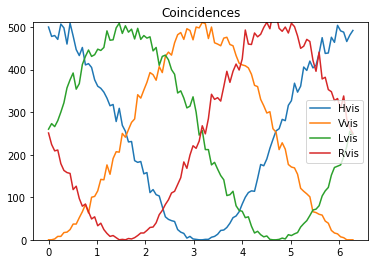

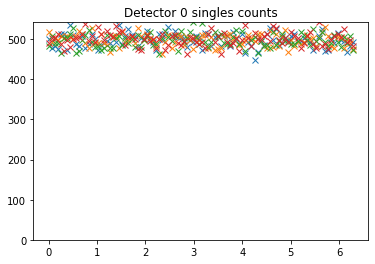

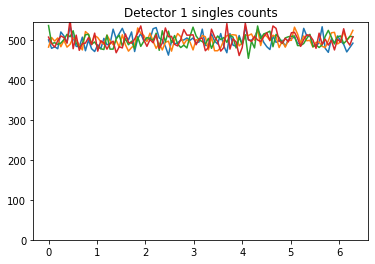

In [ ]:
plt.figure()
plt.ylim([0, max(coincidence)])
plt.plot(fringe_domain, coincidenceH, label = "Hvis")
plt.plot(fringe_domain, coincidenceV, label = "Vvis")
plt.plot(fringe_domain, coincidenceL, label = "Lvis")
plt.plot(fringe_domain, coincidenceR, label = "Rvis")
plt.title("Coincidences")
plt.legend()
plt.figure()
plt.ylim([0, max(detector0_singles)])
plt.plot(fringe_domain, detector0_singlesH, 'x')
plt.plot(fringe_domain, detector0_singlesV, 'x')
plt.plot(fringe_domain, detector0_singlesL, 'x')
plt.plot(fringe_domain, detector0_singlesR, 'x')
plt.title("Detector 0 singles counts")
plt.figure()
plt.ylim([0, max(detector1_singles)])
plt.plot(fringe_domain, detector1_singlesH)
plt.plot(fringe_domain, detector1_singlesV)
plt.plot(fringe_domain, detector1_singlesL)
plt.plot(fringe_domain, detector1_singlesR)
plt.title("Detector 1 singles counts")

In [ ]:
original_state = (complex(sqrt(3)/2), complex(0), complex(0), complex(1/2))
# original_state = (complex(1/sqrt(2)), complex(0), complex(0), complex(1/sqrt(2)))

for theta in np.linspace(0, 2*np.pi, num = 10):
    bell_state = [FreeQuantumState(), FreeQuantumState()]
    bell_state[0].combine_state(bell_state[1])
    bell_state[0].set_state(original_state)
    bell_state[0].split_states()

    pol_single_qubit.rotate({0:theta})
    pol_single_qubit.get(bell_state[0])

    pol_single_qubit.rotate({0:np.pi})
    pol_single_qubit.get(bell_state[1])

    print(bell_state[0].measure(one_qubit_basis, default_rng, return_prob = True))

    print(bell_state[1].measure(one_qubit_basis, default_rng, return_prob = True))

(0.7499999999999999+0j)
(0.25+0j)
(0.6915111107797446+0j)
(0.25+0j)
(0.5434120444167324+0j)
(0.25+0j)
(0.37500000000000006+0j)
(0.25+0j)
(0.2650768448035229+0j)
(0.25+0j)
(0.26507684480352284+0j)
(0.25+0j)
(0.37499999999999983+0j)
(0.25+0j)
(0.5434120444167324+0j)
(0.25+0j)
(0.6915111107797441+0j)
(0.25+0j)
(0.7499999999999999+0j)
(0.25+0j)


entity name: signal_receiver
entity name: signal_receiver.signal_detector
entity name: signal_receiver.idler_detector
entity name: two_qubit_polarizer
entity name: one_qubit_polarizer
entity name: idler_receiver
entity name: Polariation_source_node
entity name: Polariation_source_node.spdc_source
entity name: qc_Polariation_source_node_signal_receiver
entity name: qc_Polariation_source_node_idler_receiver

New Phase angle: 0.0


/home/asingal/home/Visibility-SeQUeNCe-research/absorptive_experiment_misc/definitions.py:477: ComplexWarning: Casting complex values to real discards the imaginary part
  single = np.random.choice([1,2,0], p = [det_idler_remaining_prob, det_signal_remaining_prob, 1-det_signal_remaining_prob-det_idler_remaining_prob])



New Phase angle: 0.12566370614359174

New Phase angle: 0.25132741228718347

New Phase angle: 0.3769911184307752

New Phase angle: 0.5026548245743669

New Phase angle: 0.6283185307179586

New Phase angle: 0.7539822368615504

New Phase angle: 0.8796459430051422

New Phase angle: 1.0053096491487339

New Phase angle: 1.1309733552923256

New Phase angle: 1.2566370614359172

New Phase angle: 1.3823007675795091

New Phase angle: 1.5079644737231008

New Phase angle: 1.6336281798666925

New Phase angle: 1.7592918860102844

New Phase angle: 1.884955592153876

New Phase angle: 2.0106192982974678

New Phase angle: 2.1362830044410597

New Phase angle: 2.261946710584651

New Phase angle: 2.387610416728243

New Phase angle: 2.5132741228718345

New Phase angle: 2.6389378290154264

New Phase angle: 2.7646015351590183

New Phase angle: 2.8902652413026098

New Phase angle: 3.0159289474462017

New Phase angle: 3.1415926535897936

New Phase angle: 3.267256359733385

New Phase angle: 3.392920065876977

New

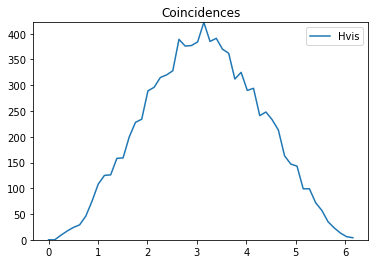

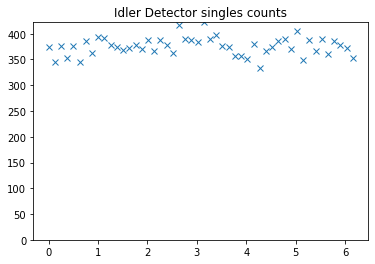

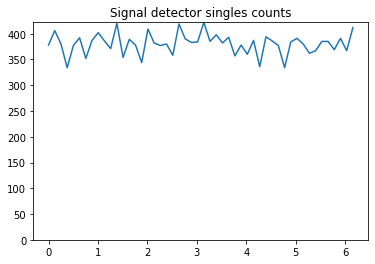

In [ ]:
# from typing import List, Callable, TYPE_CHECKING
from pathlib import Path
from copy import copy
from matplotlib import pyplot as plt

# if TYPE_CHECKING:
#     from src.components.photon import Photon

import numpy as np

from absorptive_experiment_misc.definitions import *

from src.kernel.event import Event
from src.kernel.process import Process
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import KET_STATE_FORMALISM, DENSITY_MATRIX_FORMALISM

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.7,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.15, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.15,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 10.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 10.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,

    # experiment settings
    "num_bs_trials_per_phase" : 300,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=50, endpoint=False)),

    "MODE_NUM": 10,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)

signal_receiver_name = "signal_receiver"
idler_receiver_name = "idler_receiver"
signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

source_node_name = "Polariation_source_node"
source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

coincidences = []
det_idler_singles = []
det_signal_singles = []

for i, phase in enumerate(params["phase_settings"]):
    timeline.init()
    print("\nNew Phase angle:", phase)
    signal_receiver.rotate(phase)

    for j in range(params["num_bs_trials_per_phase"]):
        source_node.start()
        timeline.run()
    coincidences.append(signal_receiver.coincidence_count)
    det_idler_singles.append(signal_receiver.det_idler_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_idler_singles_count = 0
    det_signal_singles.append(signal_receiver.det_signal_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_signal_singles_count = 0
    signal_receiver.coincidence_count = 0
        
plt.figure()
plt.ylim([0, max(coincidences)])
# print("len of phases", len(params["num_bs_trials_per_phase"]))
plt.plot(params["phase_settings"], coincidences, label = "Hvis")

plt.title("Coincidences")
plt.legend()
plt.figure()
plt.ylim([0, max(det_idler_singles)])
plt.plot(params["phase_settings"], det_idler_singles, 'x')
plt.title("Idler Detector singles counts")
plt.figure()
plt.ylim([0, max(det_signal_singles)])
plt.plot(params["phase_settings"], det_signal_singles)
plt.title("Signal detector singles counts")

plt.show()

entity name: signal_receiver
entity name: signal_receiver.signal_detector
entity name: signal_receiver.idler_detector
entity name: two_qubit_polarizer
entity name: one_qubit_polarizer
entity name: idler_receiver
entity name: Polariation_source_node
entity name: Polariation_source_node.spdc_source
entity name: qc_Polariation_source_node_signal_receiver
entity name: qc_Polariation_source_node_idler_receiver

New Phase angle: 0.0


/home/asingal/home/Visibility-SeQUeNCe-research/absorptive_experiment_misc/definitions.py:477: ComplexWarning: Casting complex values to real discards the imaginary part
  single = np.random.choice([1,2,0], p = [det_idler_remaining_prob, det_signal_remaining_prob, 1-det_signal_remaining_prob-det_idler_remaining_prob])



New Phase angle: 0.12566370614359174

New Phase angle: 0.25132741228718347

New Phase angle: 0.3769911184307752

New Phase angle: 0.5026548245743669

New Phase angle: 0.6283185307179586

New Phase angle: 0.7539822368615504

New Phase angle: 0.8796459430051422

New Phase angle: 1.0053096491487339

New Phase angle: 1.1309733552923256

New Phase angle: 1.2566370614359172

New Phase angle: 1.3823007675795091

New Phase angle: 1.5079644737231008

New Phase angle: 1.6336281798666925

New Phase angle: 1.7592918860102844

New Phase angle: 1.884955592153876

New Phase angle: 2.0106192982974678

New Phase angle: 2.1362830044410597

New Phase angle: 2.261946710584651

New Phase angle: 2.387610416728243

New Phase angle: 2.5132741228718345

New Phase angle: 2.6389378290154264

New Phase angle: 2.7646015351590183

New Phase angle: 2.8902652413026098

New Phase angle: 3.0159289474462017

New Phase angle: 3.1415926535897936

New Phase angle: 3.267256359733385

New Phase angle: 3.392920065876977

New

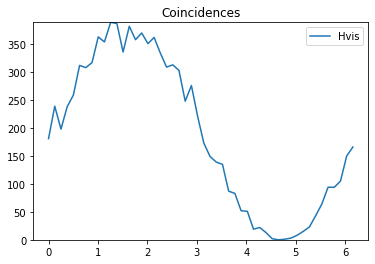

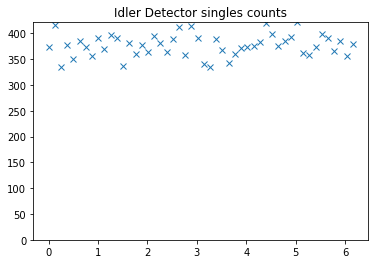

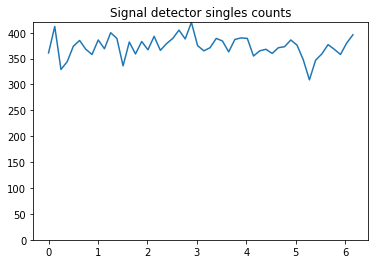

In [ ]:
# from typing import List, Callable, TYPE_CHECKING
from pathlib import Path
from copy import copy
from matplotlib import pyplot as plt

# if TYPE_CHECKING:
#     from src.components.photon import Photon

import numpy as np

from absorptive_experiment_misc.definitions import *

from src.kernel.event import Event
from src.kernel.process import Process
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import KET_STATE_FORMALISM, DENSITY_MATRIX_FORMALISM

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.7,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.15, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.15,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 10.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 10.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,

    # experiment settings
    "num_bs_trials_per_phase" : 300,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=50, endpoint=False)),

    "MODE_NUM": 10,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)

signal_receiver_name = "signal_receiver"
idler_receiver_name = "idler_receiver"
signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

source_node_name = "Polariation_source_node"
source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

coincidences = []
det_idler_singles = []
det_signal_singles = []

for i, phase in enumerate(params["phase_settings"]):
    timeline.init()
    print("\nNew Phase angle:", phase)
    signal_receiver.rotate(phase)

    for j in range(params["num_bs_trials_per_phase"]):
        source_node.start()
        timeline.run()
    coincidences.append(signal_receiver.coincidence_count)
    det_idler_singles.append(signal_receiver.det_idler_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_idler_singles_count = 0
    det_signal_singles.append(signal_receiver.det_signal_singles_count+signal_receiver.coincidence_count)
    signal_receiver.det_signal_singles_count = 0
    signal_receiver.coincidence_count = 0
        
plt.figure()
plt.ylim([0, max(coincidences)])
# print("len of phases", len(params["num_bs_trials_per_phase"]))
plt.plot(params["phase_settings"], coincidences, label = "Hvis")

plt.title("Coincidences")
plt.legend()
plt.figure()
plt.ylim([0, max(det_idler_singles)])
plt.plot(params["phase_settings"], det_idler_singles, 'x')
plt.title("Idler Detector singles counts")
plt.figure()
plt.ylim([0, max(det_signal_singles)])
plt.plot(params["phase_settings"], det_signal_singles)
plt.title("Signal detector singles counts")

plt.show()

In [2]:
# from typing import List, Callable, TYPE_CHECKING
from pathlib import Path
from copy import copy
from matplotlib import pyplot as plt

# if TYPE_CHECKING:
#     from src.components.photon import Photon

import numpy as np

from absorptive_experiment_misc.definitions import *

from src.kernel.event import Event
from src.kernel.process import Process
from src.kernel.timeline import Timeline
from src.kernel.quantum_manager import KET_STATE_FORMALISM, DENSITY_MATRIX_FORMALISM

params = {
    "QUANTUM_WAVELENGTH" : 1536.,  # wavelength of AFC memory resonant absorption, of SPDC source signal photon
    "SPDC_FREQUENCY" : 1e8,  # frequency of both SPDC sources' photon creation
    "MEAN_PHOTON_NUM" : 0.5,  # mean photon number of SPDC source on node 1

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 0.5, # efficiency of detector 1 of BSM
    "IDLER_DET_EFFICIENCY" : 0.5,  # efficiency of detector 2 of BSM
    "SIGNAL_DET_DARK" : 0,
    "IDLER_DET_DARK" : 0,
    "TEMPORAL_COINCIDENCE_WINDOW": 400,
    "RESOLUTION": 20.,
    "SIGNAL_DET_DEAD" : 5000,
    "IDLER_DET_DEAD" : 5000,

    # fibers
    "SIGNAL_DIST" : 10.,  # distance between ANL and ERC, in km
    "IDLER_DIST" : 10.,  # distance between HC and ERC, in km
    "QUNATUM_ATTENUATION" : 0.076  * 10/np.log(10),  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,
    'POLARIZATION_FIDELITY': 0.5,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "phase_settings" : (np.linspace(0, 2*np.pi, num=50, endpoint=False)),

    "MODE_NUM": 8000,
}

timeline = Timeline(1e12, formalism=DENSITY_MATRIX_FORMALISM)

signal_receiver_name = "signal_receiver"
idler_receiver_name = "idler_receiver"
signal_receiver = PolarizationReceiverNode(signal_receiver_name, timeline, params)
idler_receiver = proxyReceiver(idler_receiver_name, timeline, signal_receiver)

source_node_name = "Polariation_source_node"
source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_name, idler_receiver_name, params)

qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

coincidences = []
idler_singles = []
signal_singles = []

for idler_phase in [0, np.pi/2, np.pi, 3*np.pi/2]:
    print("\nNew Idler phase:", idler_phase)
    signal_receiver.reset()
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["phase_settings"]:
        timeline.init()
        print("New Signal phase:", signal_phase)
        signal_receiver.rotateSignal(signal_phase)

        for j in range(params["num_bs_trials_per_phase"]):
            source_node.start()
            timeline.run()

    new_signal_singles, new_idler_singles, new_coincidences = signal_receiver.get_data()
    signal_singles.append(new_signal_singles)
    idler_singles.append(new_idler_singles)
    coincidences.append(new_coincidences)
    # print("signal_counts", signal_receiver.detections[signal_receiver.signal_detector])
    # print("idler_counts", signal_receiver.detections[signal_receiver.idler_detector])

    # coincidences.append(signal_receiver.coincidence_count)
    # det_idler_singles.append(signal_receiver.det_idler_singles_count+signal_receiver.coincidence_count)
    # signal_receiver.det_idler_singles_count = 0
    # det_signal_singles.append(signal_receiver.det_signal_singles_count+signal_receiver.coincidence_count)
    # signal_receiver.det_signal_singles_count = 0
    # signal_receiver.coincidence_count = 0



New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.12566370614359174
New Signal phase: 0.25132741228718347
New Signal phase: 0.3769911184307752
New Signal phase: 0.5026548245743669
New Signal phase: 0.6283185307179586
New Signal phase: 0.7539822368615504
New Signal phase: 0.8796459430051422
New Signal phase: 1.0053096491487339
New Signal phase: 1.1309733552923256
New Signal phase: 1.2566370614359172
New Signal phase: 1.3823007675795091
New Signal phase: 1.5079644737231008
New Signal phase: 1.6336281798666925
New Signal phase: 1.7592918860102844
New Signal phase: 1.884955592153876
New Signal phase: 2.0106192982974678
New Signal phase: 2.1362830044410597
New Signal phase: 2.261946710584651
New Signal phase: 2.387610416728243
New Signal phase: 2.5132741228718345
New Signal phase: 2.6389378290154264
New Signal phase: 2.7646015351590183
New Signal phase: 2.8902652413026098
New Signal phase: 3.0159289474462017
New Signal phase: 3.1415926535897936
New Signal phase: 3.26725635973338

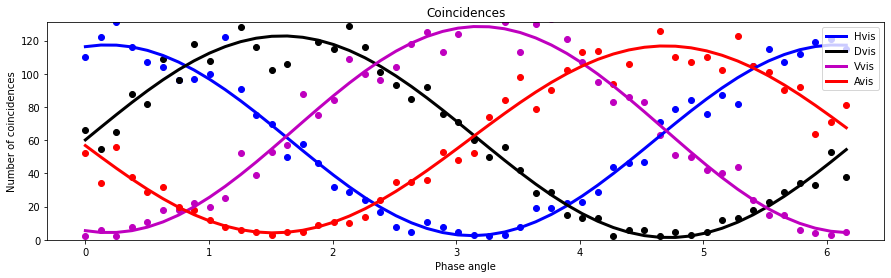

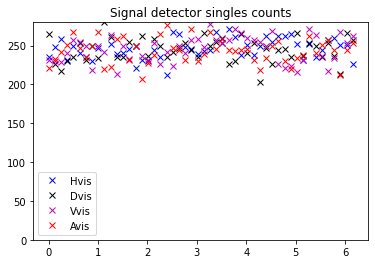

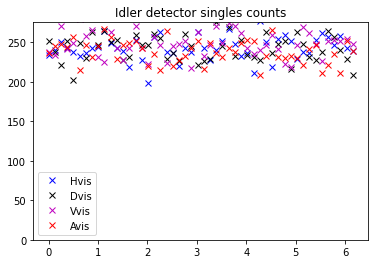

In [16]:
from scipy import optimize

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

fringe_domain = params["phase_settings"]

params0, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[0], p0=(80,1,1,1))
params1, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[1], p0=(80,1,1,1))
params2, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[2], p0=(80,1,1,1))
params3, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[3], p0=(80,1,1,1))


plt.figure(figsize=(15,4))
plt.ylim([0, max(max(coincidences))])
plt.plot(fringe_domain, coincidences[0], 'bo')
plt.plot(fringe_domain, coincidences[1], 'ko')
plt.plot(fringe_domain, coincidences[2], 'mo')
plt.plot(fringe_domain, coincidences[3], 'ro')

plt.plot(fringe_domain, sinusoid(fringe_domain, *params0), 'b',  label = "Hvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params1), 'k',  label = "Dvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params2), 'm',  label = "Vvis", linewidth = 3)
plt.plot(fringe_domain, sinusoid(fringe_domain, *params3), 'r',  label = "Avis", linewidth = 3)

plt.title("Coincidences")
plt.legend()
plt.xlabel('Phase angle')
plt.ylabel('Number of coincidences')


plt.figure()
plt.ylim([0, max(max(signal_singles))])
plt.plot(fringe_domain, signal_singles[0], 'bx', label = "Hvis")
plt.plot(fringe_domain, signal_singles[1], 'kx', label = "Dvis")
plt.plot(fringe_domain, signal_singles[2], 'mx', label = "Vvis")
plt.plot(fringe_domain, signal_singles[3], 'rx', label = "Avis")
plt.title("Signal detector singles counts")
plt.legend()


plt.figure()
plt.ylim([0, max(max(idler_singles))])
plt.plot(fringe_domain, idler_singles[0], 'bx', label = "Hvis")
plt.plot(fringe_domain, idler_singles[1], 'kx', label = "Dvis")
plt.plot(fringe_domain, idler_singles[2], 'mx', label = "Vvis")
plt.plot(fringe_domain, idler_singles[3], 'rx', label = "Avis")
plt.title("Idler detector singles counts")
plt.legend()

plt.show()

[60.23653341  1.01626383 32.94596401 63.61714646]


ValueError: Unrecognized character l in format string

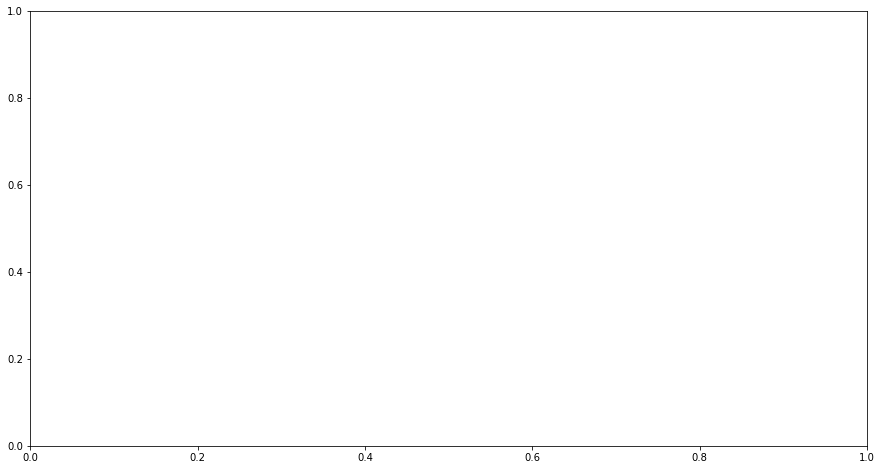

In [22]:
from scipy import optimize

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

params, params_covariance = optimize.curve_fit(sinusoid, fringe_domain, coincidences[0])
print(params)

plt.figure(figsize=(15,8))
plt.plot(fringe_domain, sinusoid(fringe_domain, *params), 'blx', label = "Hvis")